In [ ]:
!pip install opencv-contrib-python==4.4.0.44

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing the libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
cv.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# declaring the variables to check for different descriptors
feature_extraction_algo = 'orb'
feature_to_match = 'bf'

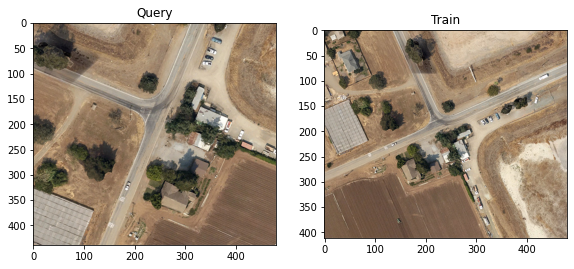

In [ ]:
# Taking the given images as input
query_photo = cv.imread('foto4B.jpg')
train_photo = cv.imread('foto4A.jpg')

query_photo = cv.cvtColor(query_photo, cv.COLOR_BGR2RGB)
train_photo = cv.cvtColor(train_photo, cv.COLOR_BGR2RGB)

plt.figure(figsize = [20,5])
plt.subplot(141);plt.imshow(query_photo, cmap='gray');plt.title("Query");
plt.subplot(142);plt.imshow(train_photo, cmap='gray');plt.title("Train");

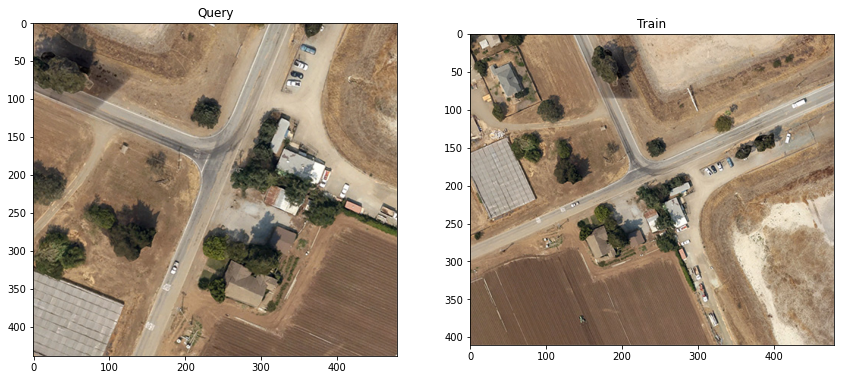

In [ ]:
query_photo_gray = cv.cvtColor(query_photo, cv.COLOR_RGB2GRAY)
train_photo_gray = cv.cvtColor(train_photo, cv.COLOR_RGB2GRAY)

plt.figure(figsize = [30,10])
plt.subplot(141);plt.imshow(query_photo, cmap='gray');plt.title("Query");
plt.subplot(142);plt.imshow(train_photo, cmap='gray');plt.title("Train");

In [ ]:
# function to select the descriptor and see what works best. ORB worked well for me.
def descriptor_selector(img, method=None):

  assert method is not None, "Please define a dedscriptor method, Accepted values are: 'sift', 'surf', 'brisk' and 'orb'."

  if method == 'sift':
    descriptor = cv.SIFT_create()

  if method == 'surf':
    descriptor = cv.SURF_create()

  if method == 'brisk':
    descriptor = cv.BRISK_create()

  if method == 'orb':
    descriptor = cv.ORB_create()

  (keypoints, features) = descriptor.detectAndCompute(img, None)

  return (keypoints, features)

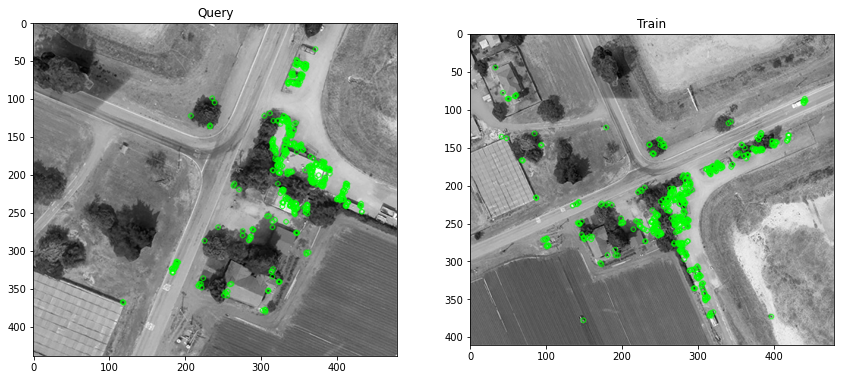

In [ ]:
# extracting the keypoints from the query and the train images.

key_query, desc_query = descriptor_selector(query_photo_gray, method = feature_extraction_algo)
key_train, desc_train = descriptor_selector(train_photo_gray, method = feature_extraction_algo)

# Drawing the extracted keypoints
query_draw = cv.drawKeypoints(query_photo_gray, key_query, None, color=(0,255,0))
train_draw = cv.drawKeypoints(train_photo_gray, key_train, None, color=(0,255,0))

plt.figure(figsize = [30,10])
plt.subplot(141);plt.imshow(query_draw, cmap='gray');plt.title("Query");
plt.subplot(142);plt.imshow(train_draw, cmap='gray');plt.title("Train");

In [ ]:
# function to initialize the object for matching using the Brute Force Matching.
# Hamming norm works best for ORB.
def creat_matching_object(method, crossCheck):

  if method=='sift' or method=='surf':
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=crossCheck)
  elif method=='orb' or method=='brisk':
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=crossCheck)

  return bf

In [ ]:
# function to plot the matches 
def key_points_matching(feature_train_img, feature_query_img, method):
  bf = creat_matching_object(method, crossCheck=True)

  best_matches = bf.match(feature_train_img, feature_query_img)

  raw_matches = sorted(best_matches, key=lambda x: x.distance)

  return raw_matches

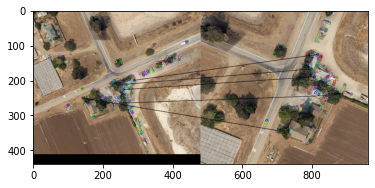

In [ ]:
# displaying the matched features
matches = key_points_matching(desc_train, desc_query, method=feature_extraction_algo)

mapped_feature_image = cv.drawMatches(train_photo, key_train, query_photo, key_query, matches[:5], None, cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image, cmap='gray')

In [ ]:
# computing the homography using RANSAC with the help of the in-built functions.
key_train_img = np.float32([keypoint.pt for keypoint in key_train ])
key_query_img = np.float32([keypoint.pt for keypoint in key_query ])

points_train = np.float32([key_train_img[m.queryIdx] for m in matches])
points_query = np.float32([key_query_img[m.trainIdx] for m in matches])

h, status = cv.findHomography(points_train, points_query, cv.RANSAC, 4)

print(h)

[[ 9.02279703e-01  8.16344300e-01 -1.33313574e+02]
 [-9.93932793e-01  9.38588475e-01  2.10163957e+02]
 [-2.24319805e-04 -3.21707151e-04  1.00000000e+00]]


In [ ]:
# width and height calculation for final result in case of vertical stitching.
width = max(query_photo.shape[1], train_photo.shape[1])
print(width)

height = query_photo.shape[0] + train_photo.shape[0]
print(height)

640
854


In [ ]:
# width and height calculation for final result in case of horizontal stitching.
width = query_photo.shape[1] + train_photo.shape[1]
print(width)

height = max(query_photo.shape[0], train_photo.shape[0])
print(height)

960
439


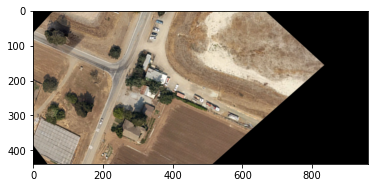

In [ ]:
# Using the warpPerspective function to transform the perspective of the train image based on the calculated homography.
result = cv.warpPerspective(train_photo, h, (width, height))
# print(result)
result1 = result.copy()

# blending the query image with the warped train image to generate the final output.
result1[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.imshow(result, cmap='gray')

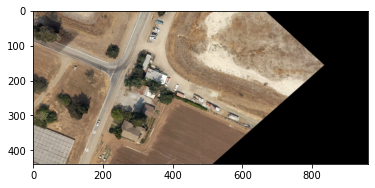

In [ ]:
plt.imshow(result1, cmap='gray')

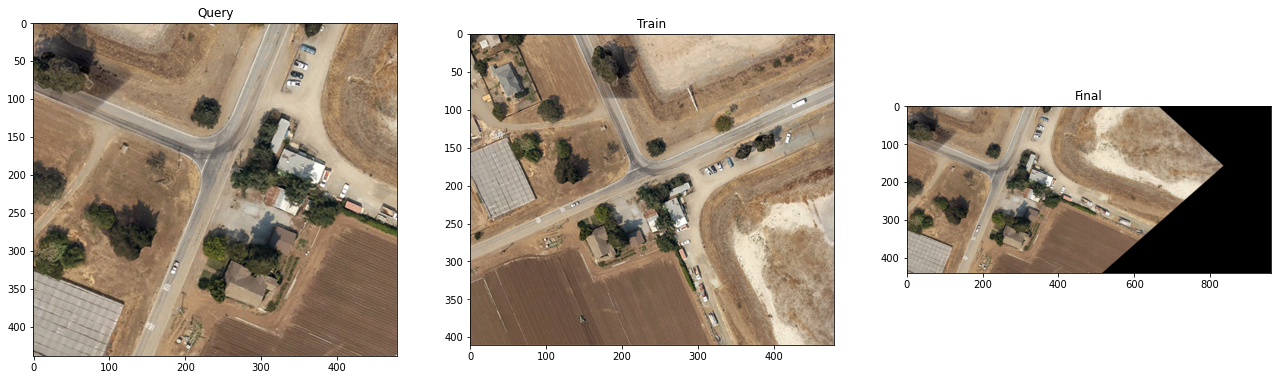

In [ ]:
plt.figure(figsize = [30,10])
plt.subplot(141);plt.imshow(query_photo, cmap='gray');plt.title("Query");
plt.subplot(142);plt.imshow(train_photo, cmap='gray');plt.title("Train");
plt.subplot(143);plt.imshow(result1, cmap='gray');plt.title("Final");